In [277]:
from pathlib import Path
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import numpy as np
import wandb
import torch
from torch import nn
from tqdm.notebook import tqdm
from itertools import product
import sys
sys.path.append(str(Path.cwd().parent))
from viz_utils import load_dfiv_model, predict_dfiv_model, load_dfiv_runs, create_latex_df, convert_to_latex_table, save_latex_str
import plotly.express as px
from src.data.demand_design import psi, f

In [278]:

from IPython.display import display, HTML
import plotly
plotly.offline.init_notebook_mode(connected=True)

# The polling here is to ensure that plotly.js has already been loaded before
# setting display alignment in order to avoid a race condition.
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

In [279]:
entity, project = "jasmineqy0", "formal_6"  
rho = 0.5
function = 'original'

In [280]:
group = 'dfiv_low_dim_parcs_noise_price_bias'
runs_bias_df = load_dfiv_runs(entity, project, filters={'group' : group})

In [281]:
noise_mean_prices = [2, 4, 8, 16]

# Noise Price Bias

In [296]:
result_df = runs_bias_df[runs_bias_df['state'].apply(lambda x: x == 'finished')]
result_df = result_df[result_df['config'].apply(lambda x: x['data_configs']['rho'] == rho)]
result_df = result_df[result_df['config'].apply(lambda x: x['data_configs']['function'] == function)]
print('Number of runs: ', len(result_df))

Number of runs:  120


In [297]:
grouped_df = result_df.groupby(result_df['config'].apply(lambda x: x['data_configs']['noise_price_bias']))

noise_price_biases = []
run_ids, run_seeds = {}, []
best_run_ids, best_run_seeds = [], []
original_mean_test_loss_list = []
original_std_test_loss_list = []
original_median_test_loss_list = []
original_test_loss_list = []
for group, group_df in grouped_df:
    n = len(group_df)
    print("Group:", group, 'Length:', n)
    
    noise_price_biases.append(group)
    
    run_id = group_df['id']
    run_ids[group] = run_id
    
    best_run_df_id = group_df['summary'].apply(lambda x: x['min_test_loss']).idxmin()
    best_run_id = group_df.loc[best_run_df_id]['id']
    best_run_ids.append(best_run_id)
    print('\t best run id: ', best_run_id)
    
    run_seed = group_df['config'].apply(lambda x: x['experiment_id'])
    run_seeds.append(run_seed)
    
    best_run_seed = group_df.loc[best_run_df_id]['config']['experiment_id']
    best_run_seeds.append(best_run_seed)
    print('\t best run seed: ', best_run_seed)
    
    test_loss_idx = group_df['summary'].apply(lambda x: True if 'min_test_loss' in x else False)
    test_loss_df = group_df[test_loss_idx]
    print('\t Number of runs with test loss: ', len(test_loss_df))

    original_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])
    original_test_loss_list.append(original_test_loss)

    min_idx, min_test_loss = np.argmin(original_test_loss), np.min(original_test_loss)
    print(f"\t min test loss: {min_test_loss}")

    original_mean_test_loss = np.mean(original_test_loss)
    original_mean_test_loss_list.append(original_mean_test_loss)
    print('\t mean test loss: ', original_mean_test_loss)

    original_std_test_loss = np.std(original_test_loss)
    original_std_test_loss_list.append(original_std_test_loss)
    print('\t std test loss: ', original_std_test_loss)

    original_median_test_loss = np.median(original_test_loss)
    original_median_test_loss_list.append(original_median_test_loss)
    print('\tmedian test loss: ', original_median_test_loss)

Group: 2 Length: 30
	 best run id:  w2jbdf9z
	 best run seed:  22
	 Number of runs with test loss:  30
	 min test loss: 98.642822265625
	 mean test loss:  143.52843755086263
	 std test loss:  25.558307931514893
	median test loss:  138.99526977539062
Group: 4 Length: 30
	 best run id:  z661efh4
	 best run seed:  24
	 Number of runs with test loss:  30
	 min test loss: 98.3909683227539
	 mean test loss:  192.67480977376303
	 std test loss:  45.553006232433646
	median test loss:  191.16251373291016
Group: 8 Length: 30
	 best run id:  unfvltea
	 best run seed:  5
	 Number of runs with test loss:  30
	 min test loss: 183.19900512695312
	 mean test loss:  340.8773920694987
	 std test loss:  77.99459978304296
	median test loss:  352.3705596923828
Group: 16 Length: 30
	 best run id:  nauiq6jl
	 best run seed:  17
	 Number of runs with test loss:  30
	 min test loss: 469.5543823242187
	 mean test loss:  688.1056884765625
	 std test loss:  82.33713857406164
	median test loss:  681.3398132324219


In [298]:
PM_SIGN = '±'
NUM_DECIMALS = 4
loss_col_name = 'MSE'

def create_combined_df(mean_df, std_df):
    combined_df = mean_df.copy()
    combined_df[loss_col_name] = combined_df[loss_col_name].astype(str)
    # combined_df['precision_correct_parents'] = combined_df['precision_correct_parents'].astype(str)
    # combined_df['recall_correct_parents'] = combined_df['recall_correct_parents'].astype(str)

    for std_row, mean_row in zip(std_df.iterrows(), mean_df.iterrows()):
        _, std_values = std_row
        mean_idx, mean_values = mean_row
        
        mean_mse, std_mse = f"{mean_values[loss_col_name]:.{NUM_DECIMALS}f}", f"{std_values[loss_col_name]:.{NUM_DECIMALS}f}"
        combined_df.at[mean_idx, loss_col_name] = f"{mean_mse} {PM_SIGN} {std_mse}"
        
        # mean_precision, std_precision = f"{mean_values['precision_correct_parents']:.{NUM_DECIMALS}f}", f"{std_values['precision_correct_parents']:.{NUM_DECIMALS}f}"
        # combined_df.at[mean_idx, 'precision_correct_parents'] = f"{mean_precision} {PM_SIGN} {std_precision}"
        
        # mean_recall, std_recall = f"{mean_values['recall_correct_parents']:.{NUM_DECIMALS}f}", f"{std_values['recall_correct_parents']:.{NUM_DECIMALS}f}"
        # combined_df.at[mean_idx, 'recall_correct_parents'] = f"{mean_recall} {PM_SIGN} {std_recall}"

    return combined_df

In [299]:
original_mean_df = pd.DataFrame({ 'mu(V)': noise_mean_prices,
                                  loss_col_name: original_mean_test_loss_list})
original_std_df = pd.DataFrame({  'mu(V)': noise_mean_prices,
                                  loss_col_name: original_std_test_loss_list})
original_combined_df = create_combined_df(original_mean_df, original_std_df)
original_combined_df

,mu(V),MSE
0,2,143.5284 ± 25.5583
1,4,192.6748 ± 45.5530
2,8,340.8774 ± 77.9946
3,16,688.1057 ± 82.3371


In [300]:
latex_str = convert_to_latex_table(original_combined_df)
save_latex_str(latex_str, f'hetero.tex')
print(latex_str)

\begin{tabular}{rl}
\toprule
 mu(V) &                MSE \\
\midrule
     2 & 143.5284 $\pm$ 25.5583 \\
     4 & 192.6748 $\pm$ 45.5530 \\
     8 & 340.8774 $\pm$ 77.9946 \\
    16 & 688.1057 $\pm$ 82.3371 \\
\bottomrule
\end{tabular}



In [301]:
# run_ids = dict(zip(noise_price_biases, run_ids))
# run_seeds = dict(zip(noise_price_biases, run_seeds))

# best_run_ids = dict(zip(noise_price_biases, best_run_ids))
# best_run_seeds = dict(zip(noise_price_biases, best_run_seeds))
# print('Best run ids: ', best_run_ids)
# print('Best run seeds: ', best_run_seeds)

In [302]:
# best_run = runs_df.iloc[min_idx]
# assert best_run['summary']['test loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
# best_run_name, best_run_id = best_run['name'], best_run['id']
# print(f'best run name: {best_run_name}, best run id: {best_run_id}')

# run_path_original = '/'.join([entity, project, best_run_id])
# print(f'best run path: {run_path_original}')

# dfiv_original_model = load_dfiv_model(run_path_original)

## CATE

### Prep

In [303]:
num_point = 200
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
time = np.linspace(0.0, 10, num_point)
emotion = (np.ones(num_point) * np.mean(emotion_range))
# covariate = np.c_[time, emotion]

In [304]:
true_demands = {}
mean_pred_demands = {}
max_pred_demands = {}
min_pred_demands = {}
std_pred_demands = {}
dfiv_bias_models = {}

### Compute

In [305]:
# pred_demands = []

# for id in tqdm(result_df['id'], position=0, leave=True, desc='model'):
#     run_path = f'{entity}/{project}/{id}'
#     dfiv_model = load_dfiv_model(run_path)
    
#     emotions = np.repeat(emotion_range.reshape(-1, 1), num_point, axis=0)
#     prices = np.tile(price[:, np.newaxis], (len(emotion_range), 1))
#     times = np.tile(time[:, np.newaxis], (len(emotion_range), 1))
#     covariates = np.c_[times, emotions]
    
#     tmp_demands = predict_dfiv_model(dfiv_model, prices, covariates).reshape(-1, num_point)
    
#     mean_demand = tmp_demands.mean(axis=0).reshape(1, -1)
#     pred_demands.append(mean_demand)

# pred_demands = np.vstack(pred_demands)
# print(pred_demands.shape)

In [306]:
for noise_price_mean in noise_mean_prices:
    pred_demands = []
    price = np.ones(num_point) * (25 + noise_price_mean)

    for id in tqdm(run_ids[noise_price_mean], position=0, leave=True, desc=f'noise price mean: {noise_price_mean}'):
        run_path = f'{entity}/{project}/{id}'
        dfiv_model = load_dfiv_model(run_path)
        
        emotions = np.repeat(emotion_range.reshape(-1, 1), num_point, axis=0)
        prices = np.tile(price[:, np.newaxis], (len(emotion_range), 1))
        times = np.tile(time[:, np.newaxis], (len(emotion_range), 1))
        covariates = np.c_[times, emotions]
        
        tmp_demands = predict_dfiv_model(dfiv_model, prices, covariates).reshape(-1, num_point)
        mean_demand = tmp_demands.mean(axis=0).reshape(1, -1)
        pred_demands.append(mean_demand)
    
    pred_demands = np.vstack(pred_demands)
    mean_pred_demand = np.mean(pred_demands, axis=0)
    min_pred_demand = np.min(pred_demands, axis=0)
    max_pred_demand = np.max(pred_demands, axis=0)
    std_pred_demand = np.std(pred_demands, axis=0)
    error_min_pred_demand = mean_pred_demand - min_pred_demand
    error_max_pred_demand = max_pred_demand - mean_pred_demand
    
    true_demand = f(function, price, time, emotion)
    
    true_demands[noise_price_mean] = true_demand
    std_pred_demands[noise_price_mean] = std_pred_demand
    mean_pred_demands[noise_price_mean] = mean_pred_demand
    min_pred_demands[noise_price_mean] = mean_pred_demand - error_min_pred_demand
    max_pred_demands[noise_price_mean] = mean_pred_demand + error_max_pred_demand

noise price mean: 2:   0%|          | 0/30 [00:00<?, ?it/s]

noise price mean: 4:   0%|          | 0/30 [00:00<?, ?it/s]

noise price mean: 8:   0%|          | 0/30 [00:00<?, ?it/s]

noise price mean: 16:   0%|          | 0/30 [00:00<?, ?it/s]

### Visualization

In [311]:
# idx2pos = { : (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}
idx2pos = {2: 0, 16: 1}
# idx2mean = dict(zip(range(len(noise_mean_prices)), noise_mean_prices))

In [312]:
plt.rcParams.update({
    'font.size': 16,
    "figure.figsize": [8, 10],
})

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


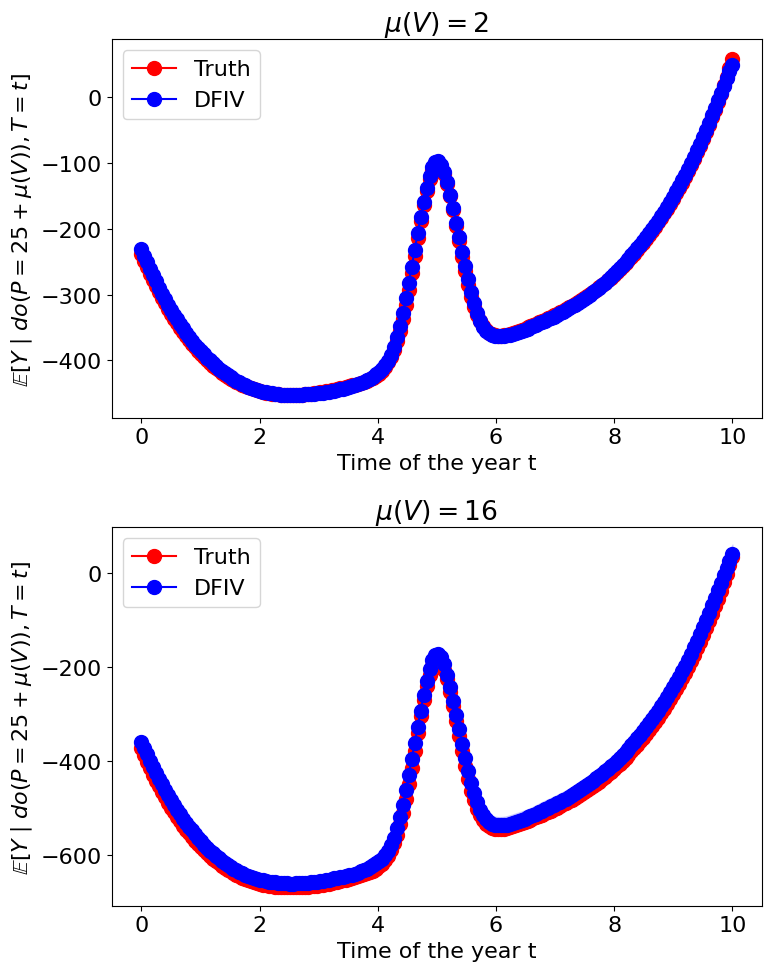

In [313]:
fig, axs = plt.subplots(2, 1)

ylim = [-700, 100]
markersize = 20

for mean in idx2pos.keys():
    pos = idx2pos[mean],
    title = f'$\mu(V)={mean}$'
    y_label = '$\mathbb{E}' + f'[Y\mid do(P=25+\mu(V)), T=t]$'
    
    print(type(axs[pos]))
    axs[pos].plot(time, true_demands[mean], color='red', label='Truth', marker='.', markersize=markersize)
    axs[pos].plot(time, mean_pred_demands[mean], color='blue', label='DFIV', marker='.', markersize=markersize)
    axs[pos].set_title(title)
    axs[pos].set_xlabel('Time of the year t')
    axs[pos].set_ylabel(y_label)
    # axs[pos].set_ylim(ylim)
    axs[pos].legend(loc='upper left')
    axs[pos].fill_between(time, mean_pred_demands[mean]-std_pred_demands[mean], mean_pred_demands[mean]+std_pred_demands[mean], alpha=0.15, color='b')
    # axs[pos].fill_between(time, min_pred_demands[i], max_pred_demands[i], alpha=0.15, color='b')
    
plt.tight_layout()
plt.savefig('images/hidden_confounder_CATE.pdf')

In [314]:
mses = []

for mean in noise_mean_prices:
    mse = np.mean((true_demands[mean] - mean_pred_demands[mean])**2)
    mses.append(mse)

mses

[13.270909943564202,
 34.880251502930925,
 121.00998061885304,
 145.45655025544812]

## ATE

### Prep

In [315]:
num_point = 200
# vary p: fix t = E[t] = 5, S = E[S] = 4
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
# price = np.ones(num_point) * np.linspace(10, 35, num_point)
time_range = np.linspace(0.0, 10, num_point)
noise_mean_prices = [2, 4, 8, 16]

In [316]:
true_demands = {}
mean_pred_demands = {}
max_pred_demands = {}
min_pred_demands = {}
std_pred_demands = {}
dfiv_bias_models = {}

### Compute

In [317]:
exp_min_prices, exp_max_prices = [], []
for noise_price_bias in noise_price_biases:
    boostrap_size = 5000
    boostrap_time = np.linspace(0.0, 10, boostrap_size)
    # E[C] = 0, E[V] = noise_price_bias -> E[P | t] = 25 + (0 + 3) * psi(t) + noise_price_bias
    exp_true_price =  25 + (0 + 3) * psi(function, boostrap_time) + noise_price_bias
    exp_min_price, exp_max_price = np.round(np.min(exp_true_price)), np.round(np.max(exp_true_price))
    exp_min_prices.append(exp_min_price)
    exp_max_prices.append(exp_max_price)
    
exp_price_ranges = dict(zip(noise_price_biases, zip(exp_min_prices, exp_max_prices)))
print('experiment price ranges: ', exp_price_ranges)

mean2prices = [np.linspace(exp_min_price, exp_max_price, num_point) for exp_min_price, exp_max_price in exp_price_ranges.values()]
mean2prices = dict(zip(noise_price_biases, mean2prices))

experiment price ranges:  {2: (17.0, 27.0), 4: (19.0, 29.0), 8: (23.0, 33.0), 16: (31.0, 41.0)}


In [318]:
# true_demands = []

# for price in prices:
#     G = np.mean(psi(function, time)) * np.mean(emotion_range)
#     coef = G - 2
#     offset = 100 + 10 * G
#     true_demand = coef * price + offset
#     true_demands.append(true_demand)

In [319]:
# pred_demands = []

# for id in tqdm(result_df['id'], desc='model', position=0):
#     run_path = f'{entity}/{project}/{id}'
#     dfiv_model = load_dfiv_model(run_path)
    
#     # Generate the combinations of emotion and time
#     emotions, times = np.meshgrid(emotion_range, time_range)
#     combs = np.column_stack((emotions.ravel(), times.ravel()))  
    
#     # Create the covariates array
#     time = np.repeat(combs[:, 1].reshape(-1, 1), num_point, axis=0)
#     emotion = np.repeat(combs[:, 0].reshape(-1, 1), num_point, axis=0)
#     covariates = np.concatenate((time, emotion), axis=1)

#     prices = np.tile(price[:, np.newaxis], (len(combs), 1))
    
#     tmp_pred_demands = predict_dfiv_model(dfiv_model, prices, covariates).reshape(-1, num_point)
#     mean_pred_demand = np.mean(tmp_pred_demands, axis=0).reshape(1, -1)

#     pred_demands.append(mean_pred_demand)

# pred_demands = np.vstack(pred_demands)

In [320]:
for noise_price_mean in noise_mean_prices:
    pred_demands = []
    
    price = mean2prices[noise_price_mean]
    for id in tqdm(run_ids[noise_price_mean], position=0, desc=f'noise price mean: {noise_price_mean}'):
        run_path = f'{entity}/{project}/{id}'
        dfiv_model = load_dfiv_model(run_path)
        
        # Generate the combinations of emotion and time
        emotions, times = np.meshgrid(emotion_range, time_range)
        combs = np.column_stack((emotions.ravel(), times.ravel())) 
        
        # Create the covariates array
        time = np.repeat(combs[:, 1].reshape(-1, 1), num_point, axis=0)
        emotion = np.repeat(combs[:, 0].reshape(-1, 1), num_point, axis=0)
        covariates = np.concatenate((time, emotion), axis=1) 
        
        prices = np.tile(price[:, np.newaxis], (len(combs), 1))
        # print(prices.shape, covariates.shape)
        tmp_pred_demands = predict_dfiv_model(dfiv_model, prices, covariates).reshape(-1, num_point)
        mean_pred_demand = np.mean(tmp_pred_demands, axis=0).reshape(1, -1)
    
        pred_demands.append(mean_pred_demand)

    pred_demands = np.vstack(pred_demands)
    assert pred_demands.shape == (len(run_ids[noise_price_mean]), num_point), 'pred demand shape not correct'
    
    mean_pred_demand = np.mean(pred_demands, axis=0)
    min_pred_demand = np.min(pred_demands, axis=0)
    max_pred_demand = np.max(pred_demands, axis=0)
    std_pred_demand = np.std(pred_demands, axis=0)
    error_min_pred_demand = mean_pred_demand - min_pred_demand
    error_max_pred_demand = max_pred_demand - mean_pred_demand
    
    tmp_time = []
    for time in time_range:
        pred = psi(function, time)
        tmp_time.append(pred)
    G = np.mean(tmp_time) * np.mean(emotion_range)
    coef = G - 2
    offset = 100 + 10 * G
    true_demand = coef * price + offset
    
    true_demands[noise_price_mean] = true_demand
    mean_pred_demands[noise_price_mean] = mean_pred_demand
    std_pred_demands[noise_price_mean] = std_pred_demand
    min_pred_demands[noise_price_mean] = mean_pred_demand - error_min_pred_demand
    max_pred_demands[noise_price_mean] = mean_pred_demand + error_max_pred_demand

noise price mean: 2:   0%|          | 0/30 [00:00<?, ?it/s]

noise price mean: 4:   0%|          | 0/30 [00:00<?, ?it/s]

noise price mean: 8:   0%|          | 0/30 [00:00<?, ?it/s]

noise price mean: 16:   0%|          | 0/30 [00:00<?, ?it/s]

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


In [321]:
# original_demand = []
# for p in price:
#     p = (np.ones(num_point) * p)[:, np.newaxis]
#     pred = np.mean((predict_dfiv_model(dfiv_original_model, p, covariate)))
#     original_demand.append(pred)

# mu_2_pred_demand = []
# for p in price:
#     p = (np.ones(num_point) * p)[:, np.newaxis]
#     pred = np.mean((predict_dfiv_model(dfiv_mu_2_model, p, covariate)))
#     mu_2_pred_demand.append(pred)

# mu_4_pred_demand = []
# for p in price:
#     p = (np.ones(num_point) * p)[:, np.newaxis]
#     pred = np.mean((predict_dfiv_model(dfiv_mu_4_model, p, covariate)))
#     mu_4_pred_demand.append(pred)
    
# mu_8_pred_demand = []
# for p in price:
#     p = (np.ones(num_point) * p)[:, np.newaxis]
#     pred = np.mean((predict_dfiv_model(dfiv_mu_8_model, p, covariate)))
#     mu_8_pred_demand.append(pred)
    
# mu_16_pred_demand = []
# for p in price:
#     p = (np.ones(num_point) * p)[:, np.newaxis]
#     pred = np.mean((predict_dfiv_model(dfiv_hetero_mu_16_model, p, covariate)))
#     mu_16_pred_demand.append(pred)

### Visualization

In [325]:
# idx2pos = { 1: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}
idx2pos = {2: 0, 16: 1}
# idx2mean = dict(zip(range(len(noise_mean_prices)), noise_mean_prices))

In [326]:
plt.rcParams.update({
    'font.size': 16,
    "figure.figsize": [8, 10],
})

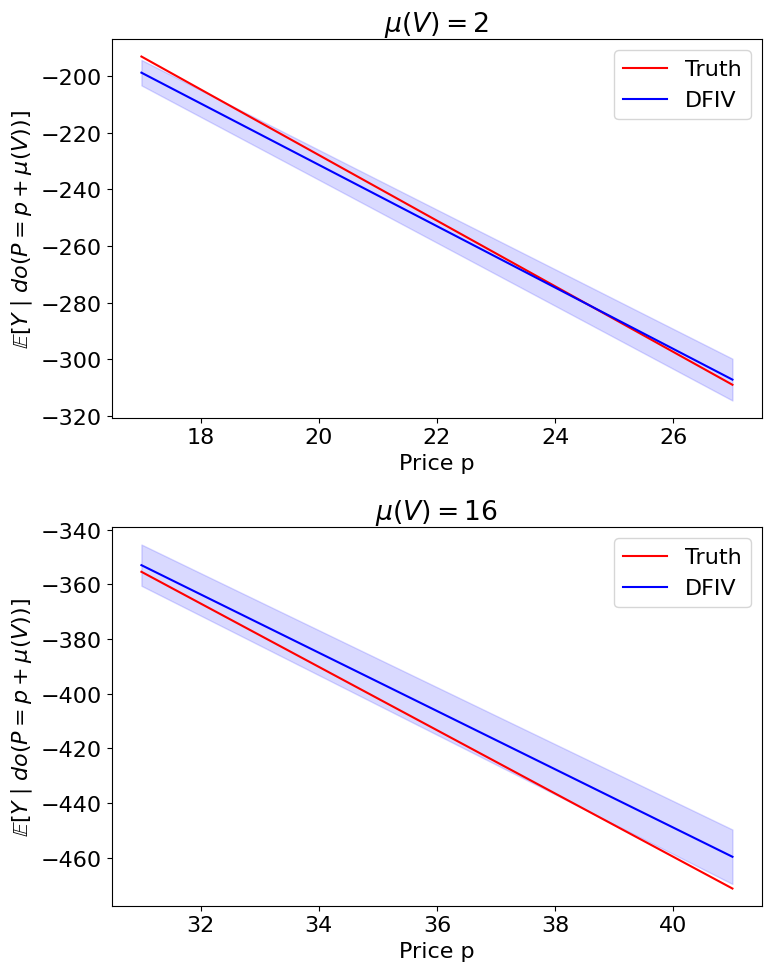

In [328]:
fig, axs = plt.subplots(2, 1)

ylim = [-500, -150]

# for i in range(1):
for mean in idx2pos.keys():
    pos = idx2pos[mean]
    # pos, mean = idx2pos[i], idx2mean[i]
    title = f'$\mu(V)={mean}$'
    y_label = '$\mathbb{E}' + f'[Y\mid do(P=p+\mu(V))]$'
    
    axs[pos].plot(mean2prices[mean], true_demands[mean], color='red', label='Truth')
    axs[pos].plot(mean2prices[mean], mean_pred_demands[mean], color='blue', label='DFIV')
    axs[pos].set_title(title)
    axs[pos].set_xlabel('Price p')
    axs[pos].set_ylabel(y_label)
    # axs[pos].set_ylim(ylim)
    axs[pos].legend(loc='upper right')
    axs[pos].fill_between(mean2prices[mean], mean_pred_demands[mean]-std_pred_demands[mean], mean_pred_demands[mean]+std_pred_demands[mean], alpha=0.15, color='b')
    # axs[pos].fill_between(prices[mean], min_pred_demands[i], max_pred_demands[i], alpha=0.15, color='b')
    
plt.tight_layout()
plt.savefig('images/hidden_confounder_ATE.pdf')

In [ ]:
mses = []

for i in range(len(noise_mean_prices)):
    mse = np.mean((true_demands[i] - mean_pred_demands[i])**2)
    mses.append(mse)

mses

[8.571159452019726, 7.106717450999071, 35.196519139807435, 56.4703916943621]

In [ ]:
# fig, ax = plt.subplots()
# price = price.squeeze()
# l1 = ax.plot(time, true_demand, color='red', label='Truth')
# # l2 = ax.plot(time, original_demand, color='blue', label='DFIV: original')
# l2 = ax.plot(time, mu_2_pred_demand, color='blue', label='DFIV: $\mu(V)=2$ ')
# l3 = ax.plot(time, mu_4_pred_demand, color='pink', label='DFIV: $\mu(V)=4$ ')
# l4 = ax.plot(time, mu_8_pred_demand, color='orange', label='DFIV: $\mu(V)=8$ ')
# l5 = ax.plot(time, mu_16_pred_demand, color='green', label='DFIV: $\mu(V)=16$ ')

# ax.legend()

# ax.set_xlabel('Time t')
# ax.set_ylabel('$\mathbb{E}[Y\mid do(P=p)]$')
# plt.savefig(f'images/ATE_mean_mu.pdf')
# plt.show()